# Imports and loading data

In [1]:
 !rm -r emerging_entities_17

In [2]:
! git clone https://github.com/leondz/emerging_entities_17.git

Cloning into 'emerging_entities_17'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [3]:
!pip install boto3 jsonnet jsonpickle tensorboardX conllu overrides word2number py-rouge
!pip install --no-deps allennlp==1.1.0 allennlp_models==1.4.1

!pip install \
transformers==3.0.1 \
seqeval \
tqdm \
flair \
sklearn_crfsuite \
nltk

In [4]:
!pip install transformers

In [5]:
import torch
import torch.nn as nn
import transformers


import math
from tqdm import tqdm



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

In [6]:
device = torch.device('cuda:0')
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

Tesla T4


# Converting data to needed format

In [7]:
def data_to_format(path):
    data = []
    with open(path, 'r') as f:
        sentence = ''
        for line in tqdm(f.readlines()):
          line = line[:-1]
          if len(line) == 0 or len(line) == 1:
              sentence = sentence[:-1] + '\n'
              data.append(sentence)
              sentence = ''
          else:
              line = line.split('\t')
              sentence += line[0] + '###' + line[1] + '\t'
    with open('seq_' + path.split('/')[-1], 'w') as f:
        for d in data:
            f.write(d)

In [8]:
data_to_format("/content/emerging_entities_17/wnut17train.conll")
data_to_format("/content/emerging_entities_17/emerging.dev.conll")

100%|██████████| 16742/16742 [00:00<00:00, 994280.18it/s]


# Using AllenNLP

In [9]:
from allennlp.data.token_indexers import PretrainedTransformerMismatchedIndexer
from allennlp.data.dataset_readers.sequence_tagging import SequenceTaggingDatasetReader


indexer = PretrainedTransformerMismatchedIndexer('bert-large-cased')
reader = SequenceTaggingDatasetReader(token_delimiter="\t", token_indexers={'tokens': indexer})

In [10]:
train_dataset = reader.read("/content/seq_wnut17train.conll")
dev_dataset = reader.read("/content/seq_emerging.dev.conll")

reading instances: 3394it [00:00, 11515.83it/s]
reading instances: 1009it [00:00, 27621.12it/s]


In [11]:
print(train_dataset[0])

Instance with fields:
 	 tokens: TextField of length 27 with text: 
 		[@paulwalk, It, 's, the, view, from, where, I, 'm, living, for, two, weeks, ., Empire, State,
		Building, =, ESB, ., Pretty, bad, storm, here, last, evening, .]
 		and TokenIndexers : {'tokens': 'PretrainedTransformerMismatchedIndexer'} 
 	 metadata: MetadataField (print field.metadata to see specific information). 
 	 tags: SequenceLabelField of length 27 with labels:
 		['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'I-location',
		'I-location', 'O', 'B-location', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
 		in namespace: 'labels'. 



In [12]:
from allennlp.data.vocabulary import Vocabulary

vocab = Vocabulary.from_instances(train_dataset.instances)

train_dataset.index_with(vocab)
dev_dataset.index_with(vocab)

building vocab: 100%|##########| 3394/3394 [00:00<00:00, 94699.20it/s]


In [13]:
from allennlp.modules.token_embedders import PretrainedTransformerMismatchedEmbedder
from allennlp.modules.seq2seq_encoders.pytorch_seq2seq_wrapper import LstmSeq2SeqEncoder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.text_field_embedders.basic_text_field_embedder import BasicTextFieldEmbedder

embedder = PretrainedTransformerMismatchedEmbedder(model_name='bert-large-cased')
text_field_embedder = BasicTextFieldEmbedder({'tokens': embedder})
encoder = LstmSeq2SeqEncoder(input_size=embedder.get_output_dim(), hidden_size=1024, bidirectional=True, dropout = 0.5, num_layers = 5)

In [14]:
from allennlp.models import SimpleTagger
from allennlp_models.tagging import CrfTagger


model = CrfTagger(text_field_embedder=text_field_embedder, 
                      vocab=vocab, 
                      encoder=encoder,
                      calculate_span_f1 = True,
                      label_encoding = 'BIO'
                     ).cuda(device=device)

In [15]:
torch.cuda.empty_cache()

In [16]:
import torch.optim as optim
from allennlp.training.learning_rate_schedulers import LinearWithWarmup, ReduceOnPlateauLearningRateScheduler, SlantedTriangular
from allennlp.training import GradientDescentTrainer
from torch.utils.data import DataLoader
from allennlp.data import allennlp_collate
from datetime import datetime



num_epochs = 20
batch_size = 8
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)

optimizer = optim.Adam(model.parameters(), lr=3e-5, betas=(0.9, 0.98))
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                               collate_fn=allennlp_collate, shuffle=True)
val_data_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, collate_fn=allennlp_collate)
lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, patience=1, factor=0.5)


date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')


trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=train_data_loader,
    validation_data_loader=val_data_loader,
    num_epochs=num_epochs,
    cuda_device=device,
    learning_rate_scheduler=lr_scheduler,
    num_gradient_accumulation_steps=1,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/allennlp/modules/conditional_random_field.py:399: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  mask_indices = prediction_mask.nonzero().squeeze()
accuracy: 0.9298, accuracy3: 0.9357, precision-overall: 0.0010, recall-overall: 0.0008, f1-measure-overall: 0.0009, batch_loss: 36.5652, loss: 62.1652 ||:  69%|######8   | 292/425 [02:54<01:19,  1.68it/s]


In [17]:
from allennlp.predictors.sentence_tagger import SentenceTaggerPredictor
predictor = SentenceTaggerPredictor(model, reader)

preds = predictor.predict(' '.join(list(map(str,list(train_dataset[0].fields['tokens'])))))
list(zip(preds['words'], preds['tags']))

[('@paulwalk', 'O'),
 ('It', 'O'),
 ("'s", 'O'),
 ('the', 'O'),
 ('view', 'O'),
 ('from', 'O'),
 ('where', 'O'),
 ('I', 'O'),
 ("'", 'O'),
 ('m', 'O'),
 ('living', 'O'),
 ('for', 'O'),
 ('two', 'O'),
 ('weeks', 'O'),
 ('.', 'O'),
 ('Empire', 'O'),
 ('State', 'O'),
 ('Building', 'O'),
 ('=', 'O'),
 ('ESB', 'O'),
 ('.', 'O'),
 ('Pretty', 'O'),
 ('bad', 'O'),
 ('storm', 'O'),
 ('here', 'O'),
 ('last', 'O'),
 ('evening', 'O'),
 ('.', 'O')]

# Not using AllenNLP

In [18]:
!pip install flair

  Using cached https://files.pythonhosted.org/packages/d5/43/cfe4ee779bbd6a678ac6a97c5a5cdeb03c35f9eaebbb9720b036680f9a2d/transformers-4.6.1-py3-none-any.whl
     |████████████████████████████████| 61kB 6.9MB/s 
  Using cached https://files.pythonhosted.org/packages/d4/e2/df3543e8ffdab68f5acc73f613de9c2b155ac47f162e725dcac87c521c11/tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: allennlp 1.1.0 has requirement torch<1.7.0,>=1.6.0, but you'll have torch 1.7.1 which is incompatible.
ERROR: allennlp 1.1.0 has requirement transformers<3.1,>=3.0, but you'll have transformers 4.6.1 which is incompa

In [19]:
from flair.datasets import ColumnCorpus


data_folder = '/content/emerging_entities_17/'

corpora = ColumnCorpus(data_folder, 
                      {0 : 'text', 1 : 'ner'},
                      train_file='wnut17train.conll',
                      test_file='emerging.test.conll',
                      dev_file='emerging.dev.conll')

print(corpora.obtain_statistics())

2021-05-27 11:29:26,120 Reading data from /content/emerging_entities_17
2021-05-27 11:29:26,121 Train: /content/emerging_entities_17/wnut17train.conll
2021-05-27 11:29:26,127 Dev: /content/emerging_entities_17/emerging.dev.conll
2021-05-27 11:29:26,128 Test: /content/emerging_entities_17/emerging.test.conll
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 3394,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 62730,
            "min": 1,
            "max": 41,
            "avg": 18.482616381850324
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 1287,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 23391,
            "min": 1,
            "max": 105,
            "avg": 18.174825174825173
        }
    },
    "DEV": {
        "dataset": 

In [20]:
def create_dataset(flair_dataset):
    dataset = []
    
    for sent in flair_dataset:
        tokens = [w.text for w in sent]
        labels = [w.get_tag('ner').value for w in sent]
        dataset.append((tokens, labels))
        
    return dataset

In [21]:
train_dataset = create_dataset(corpora.train)
dev_dataset = create_dataset(corpora.dev)
test_dataset= create_dataset(corpora.test)

In [22]:
train_dataset[0]

(['@paulwalk',
  'It',
  "'s",
  'the',
  'view',
  'from',
  'where',
  'I',
  "'m",
  'living',
  'for',
  'two',
  'weeks',
  '.',
  'Empire',
  'State',
  'Building',
  '=',
  'ESB',
  '.',
  'Pretty',
  'bad',
  'storm',
  'here',
  'last',
  'evening',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-location',
  'I-location',
  'I-location',
  'O',
  'B-location',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [23]:
word_to_ix = {}
tag_to_ix = {}

word_to_ix['PAD'] = 0
tag_to_ix['PAD'] = 0

for element in train_dataset:
    words, tags = element
    for word in words:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

print('Vocabulary to convert words to indexes:')
print(dict(list(word_to_ix.items())[:100]))

print()

print('Vocabulary to convert tags to indexes:')
print(tag_to_ix)

Vocabulary to convert words to indexes:
{'PAD': 0, '@paulwalk': 1, 'It': 2, "'s": 3, 'the': 4, 'view': 5, 'from': 6, 'where': 7, 'I': 8, "'m": 9, 'living': 10, 'for': 11, 'two': 12, 'weeks': 13, '.': 14, 'Empire': 15, 'State': 16, 'Building': 17, '=': 18, 'ESB': 19, 'Pretty': 20, 'bad': 21, 'storm': 22, 'here': 23, 'last': 24, 'evening': 25, 'From': 26, 'Green': 27, 'Newsfeed': 28, ':': 29, 'AHFA': 30, 'extends': 31, 'deadline': 32, 'Sage': 33, 'Award': 34, 'to': 35, 'Nov': 36, '5': 37, 'http://tinyurl.com/24agj38': 38, 'Pxleyes': 39, 'Top': 40, '50': 41, 'Photography': 42, 'Contest': 43, 'Pictures': 44, 'of': 45, 'August': 46, '2010': 47, '...': 48, 'http://bit.ly/bgCyZ0': 49, '#photography': 50, 'today': 51, 'is': 52, 'my': 53, 'day': 54, 'at': 55, 'office': 56, '4Dbling': 57, 'place': 58, 'til': 59, 'monday': 60, ',': 61, 'party': 62, '&lt;': 63, '3': 64, 'watching': 65, 'VMA': 66, 'pre-show': 67, 'again': 68, 'lol': 69, 'it': 70, 'was': 71, "n't": 72, 'even': 73, 'a': 74, 'good': 7

In [24]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class BasicLstmTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, 
                 tagset_size, dropout_rate=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentences, lengths):
        embeds = self.word_embeddings(sentences)

        packed_embeds = pack_padded_sequence(embeds.transpose(0, 1), lengths, enforce_sorted=False)
        packed_lstm_out, _ = self.lstm(packed_embeds)
        lstm_out, _ = pad_packed_sequence(packed_lstm_out)

        tag_space = self.hidden2tag(self.dropout(lstm_out.transpose(0, 1)))
        tag_scores = F.log_softmax(tag_space, dim=-1)
        return tag_scores

In [25]:
model = BasicLstmTagger(embedding_dim=300, 
                        hidden_dim=200, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix),
                        dropout_rate=0.1).cuda()

In [26]:
def prepare_tokens(batch_tokens, word_to_ix):
    batch_token_ids = [[word_to_ix.get(tok, 0) for tok in inst] for inst in batch_tokens]
    batch_max_len = max([len(s) for s in batch_token_ids])
    
    batch_token_ids_padded = word_to_ix['PAD']*np.ones((len(batch_token_ids), batch_max_len))
    lengths = []
    for i in range(len(batch_token_ids)):
        cur_len = len(batch_token_ids[i])
        batch_token_ids_padded[i][:cur_len] = batch_token_ids[i]
        lengths.append(cur_len)

    #since all data are indices, we convert them to torch LongTensors
    return torch.LongTensor(batch_token_ids_padded), lengths


def prepare_tags(batch_tags, tag_to_ix):
    batch_tag_ids = [[tag_to_ix[tag] for tag in inst] for inst in batch_tags]
    batch_max_len = max([len(s) for s in batch_tag_ids])

    batch_tag_ids_padded = tag_to_ix['PAD']*np.ones((len(batch_tag_ids), batch_max_len))
    for i in range(len(batch_tag_ids)):
        cur_len = len(batch_tag_ids[i])
        batch_tag_ids_padded[i][:cur_len] = batch_tag_ids[i]

    #since all data are indices, we convert them to torch LongTensors
    return torch.LongTensor(batch_tag_ids_padded)


def prepare_instance_for_training(batch_instances, word_to_ix, tag_to_ix):
    tokens, lengths = prepare_tokens([inst[0] for inst in batch_instances], word_to_ix)
    tags = prepare_tags([inst[1] for inst in batch_instances], tag_to_ix)

    return tokens, lengths, tags

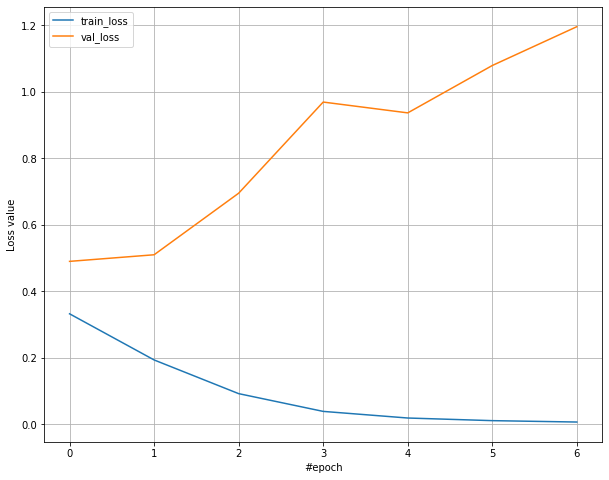

Epoch #7


In [27]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output



N_EPOCHS = 15
LEARNING_RATE = 1e-3                        
BATCH_SIZE= 8

loss_function = nn.NLLLoss(ignore_index=tag_to_ix['PAD'])
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas= (0.9, 0.98))

f_preprocess = lambda batch: prepare_instance_for_training(batch, word_to_ix, tag_to_ix)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=f_preprocess)

dev_dataloader = DataLoader(dev_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=f_preprocess)



try:
    
    losses = []
    losses_val = []
    for epoch in range(N_EPOCHS):
        print(f'Epoch #{epoch}')
        total_loss = 0
        # Переводи модель в режим тренировки
        model.train()
        # Получаем батчи
        for sentences, lengths, targets in tqdm(train_dataloader):
            # Переносим данные на видеокарту
            sentences = sentences.cuda()
            targets = targets.cuda()

            # Pytorch накапливает градиенты и нужно их занулять
            model.zero_grad()

            # Прогоняем модель
            tag_scores = model(sentences, lengths)

            # Считаем Лосс 
            loss = loss_function(tag_scores.reshape(-1, tag_scores.shape[-1]), targets.reshape(-1))
            # Считам производные
            loss.backward()
            total_loss += loss.item()
            # Обновляем параметры модели
            optimizer.step()

        losses.append(total_loss/ len(train_dataloader))
        # переводим модель в режим тестирования
        model.eval()
        total_loss_val = 0
        for sentences, lengths, targets in tqdm(dev_dataloader):
            # Переносим данные на видеокарту
            sentences = sentences.cuda()
            targets = targets.cuda()

            # не считаем градиенты
            with torch.no_grad():
                # Run our forward pass.
                tag_scores = model(sentences, lengths)

            loss = loss_function(tag_scores.reshape(-1, tag_scores.shape[-1]), targets.reshape(-1))

            total_loss_val += loss.item()
        
        losses_val.append(total_loss_val/ len(dev_dataloader))
        clear_output(wait = True)
        plt.figure(figsize=(10,8))
        plt.plot(losses, label='train_loss')
        plt.plot(losses_val, label='val_loss')
        plt.xlabel('#epoch')
        plt.ylabel('Loss value')
        plt.legend()
        plt.grid()
        plt.show()



except KeyboardInterrupt:
    pass

In [28]:
# Тестирование

pred_dataset = [inst[0] for inst in test_dataset]

f_preprocess = lambda batch: prepare_tokens(batch, word_to_ix)
pred_dataloader = DataLoader(pred_dataset, 
                             batch_size=100, 
                             num_workers=1,
                             collate_fn=f_preprocess)

model.eval()

all_preds = []
all_probas = []
with torch.no_grad():
    for sentences, lengths in pred_dataloader:
        sentences = sentences.cuda()

        tag_scores = model(sentences, lengths)
        probas, pred_tags = tag_scores.max(dim=-1)
        probas = torch.exp(probas)
        
        pred_tags = pred_tags.cpu().tolist()
        probas = probas.cpu().tolist()
        all_preds += pred_tags
        all_probas += probas

In [29]:


ix_to_tag = {v: k for k, v in tag_to_ix.items()}

pred_tags = []
pred_probas = []
for pred_sent, preds, probas in zip(pred_dataset, all_preds, all_probas):
    pred_tags.append([ix_to_tag[tag_idx] for tag_idx in preds[:len(pred_sent)]])
    pred_probas.append(probas[:len(pred_sent)])

idx = 6
list(zip(pred_dataset[idx], pred_tags[idx], pred_probas[idx]))

[('Visuals', 'O', 0.9999998807907104),
 ('of', 'O', 0.9999998807907104),
 ('the', 'O', 0.9999266862869263),
 ('avalanche', 'O', 0.9955106377601624),
 ('site', 'O', 0.9992296695709229),
 ('in', 'O', 1.0),
 ('Gurez', 'O', 0.9984663724899292),
 ('sector', 'O', 0.999924898147583),
 ('.', 'O', 1.0)]

In [30]:
!pip install seqeval

In [31]:
from seqeval.metrics import f1_score

f1_score(pred_tags, [inst[1] for inst in test_dataset])

0.0171606864274571